# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

## Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Описание данных

В таблицах **hotel_train** и **hotel_test** содержатся одинаковые столбцы:
* ***id*** — номер записи;
* ***adults*** — количество взрослых постояльцев;
* ***arrival_date_year*** — год заезда;
* ***arrival_date_month*** — месяц заезда;
* ***arrival_date_week_number*** — неделя заезда;
* ***arrival_date_day_of_month*** — день заезда;
* ***babies*** — количество младенцев;
* ***booking_changes*** — количество изменений параметров заказа;
* ***children*** — количество детей от 3 до 14 лет;
* ***country*** — гражданство постояльца;
* ***customer_type*** — тип заказчика:
  * *Contract* — договор с юридическим лицом;
  * *Group* — групповой заезд;
  * *Transient* — не связано с договором или групповым заездом;
  * *Transient-party* — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* ***days_in_waiting_list*** — сколько дней заказ ожидал подтверждения;
* ***distribution_channel*** — канал дистрибуции заказа;
* ***is_canceled*** — отмена заказа;
* ***is_repeated_guest*** — признак того, что гость бронирует номер второй раз;
* ***lead_time*** — количество дней между датой бронирования и датой прибытия;
* ***meal*** — опции заказа:
  * *SC* — нет дополнительных опций;
  * *BB* — включён завтрак;
  * *HB* — включён завтрак и обед;
  * *FB* — включён завтрак, обед и ужин.
* ***previous_bookings_not_canceled*** — количество подтверждённых заказов у клиента;
* ***previous_cancellations*** — количество отменённых заказов у клиента;
* ***required_car_parking_spaces*** — необходимость места для автомобиля;
* ***reserved_room_type*** — тип забронированной комнаты;
* ***stays_in_weekend_nights*** — количество ночей в выходные дни;
* ***stays_in_week_nights*** — количество ночей в будние дни;
* ***total_nights*** — общее количество ночей;
* ***total_of_special_requests*** — количество специальных отметок.

## Шаг 1. Откроем файлы с данными

Загружаем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve)

from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 123

Дополнительная настройка для вывода всех столбцов, так как в наших датафреймах их очень много:

In [2]:
pd.set_option('display.max_columns', None)

Напишем функцию с применением методов знакомства с данными (выведем первые строки, загрузим общую информацию, описательную характеристику о численных данных и информация о количестве пропусков):

In [3]:
def get_data_info(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print('Количество пропусков:', data.isna().sum())

Загружаем наши датафреймы:

In [4]:
try:
    hotel_train = pd.read_csv('hotel_train.csv')
    hotel_test = pd.read_csv('hotel_test.csv')
except:
    hotel_train = pd.read_csv('/datasets/hotel_train.csv')
    hotel_test = pd.read_csv('/datasets/hotel_test.csv')

Применяем нашу функцию к датасетам, чтобы познакомиться с данными:

In [5]:
get_data_info(hotel_train)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Количество пропусков: id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


In [6]:
get_data_info(hotel_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Количество пропусков: id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


### Выводы

Первое, что мы сразу можем увидеть, что обучающая выборка изначально больше тестовой примерно в 2 раза. Также отметим, что в обоих датафреймах отсутствуют пропуски. Переходим к следующему шагу - предобработка данных и исследовательский анализ.

## Шаг 2. Предобработка и исследовательский анализ данных

### Проверка и корректировка данных

Проверяем оба наших датафреймов на дубликаты:

In [7]:
print(hotel_train.duplicated().sum())
hotel_test.duplicated().sum()

0


0

Видим, что дубликаты в данных отсутствуют. Проверим соответствие столбцов в обучающем датафрейме и тестовом:

In [8]:
hotel_train.dtypes == hotel_test.dtypes

id                                True
is_canceled                       True
lead_time                         True
arrival_date_year                 True
arrival_date_month                True
arrival_date_week_number          True
arrival_date_day_of_month         True
stays_in_weekend_nights           True
stays_in_week_nights              True
adults                            True
children                          True
babies                            True
meal                              True
country                           True
distribution_channel              True
is_repeated_guest                 True
previous_cancellations            True
previous_bookings_not_canceled    True
reserved_room_type                True
booking_changes                   True
days_in_waiting_list              True
customer_type                     True
required_car_parking_spaces       True
total_of_special_requests         True
total_nights                      True
dtype: bool

Видим, что все столбцы совпадают. Выделим в отдельные переменные столбцы с категориальными данными:

In [9]:
category_features = hotel_train.select_dtypes(include='object').columns.to_list()
category_features

['arrival_date_month',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']

Далее проверим значения в наших категориальных столбцах для обоих датасетов:

In [10]:
for feature in category_features:
        print(hotel_train[feature].unique())
        print('Количество уникальных значений:', hotel_train[feature].nunique())

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
Количество уникальных значений: 12
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
Количество уникальных значений: 5
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZ

In [11]:
for feature in category_features:
        print(hotel_test[feature].unique())
        print('Количество уникальных значений:', hotel_test[feature].nunique())

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
Количество уникальных значений: 8
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']
Количество уникальных значений: 5
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'
 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'
 'MCO' 'MUS' 'SYR' 'TGO' 'IRQ' 'LKA' 'BIH' 'PRY' 'MRT' 'ABW' 'NCL' 'STP'
 'KIR' 

Видим, что в столбцах ***meal*** и ***reserved_room_type*** обнаружены пробелы в значениях в обоих датфафреймах, из-за чего в столбце ***meal*** 5 уникальных значений, когда по условию должно быть 4. Удалим лишние пробелы с помощью методов  *.str.strip()* в обоих датафреймах и тут же выведем результат на экран:

In [12]:
for column in ['meal', 'reserved_room_type']:
    hotel_train[column] = hotel_train[column].str.strip()
    print(hotel_train[column].unique())
    print('Количество уникальных значений:', hotel_train[column].nunique())
    hotel_test[column] = hotel_test[column].str.strip()
    print(hotel_test[column].unique())
    print('Количество уникальных значений:', hotel_test[column].nunique())

['BB' 'FB' 'HB' 'SC']
Количество уникальных значений: 4
['BB' 'HB' 'SC' 'FB']
Количество уникальных значений: 4
['A' 'C' 'D' 'E' 'G' 'F' 'B']
Количество уникальных значений: 7
['A' 'E' 'G' 'D' 'F' 'C' 'B']
Количество уникальных значений: 7


Преобразование прошло успешно. Также удалим из датасетов столбцы ***id*** и ***country***, так как они в будущем нам не пригодятся:

In [13]:
hotel_train.drop(columns=['id', 'country'], inplace=True)
hotel_test.drop(columns=['id', 'country'], inplace=True)

### Исследовательский анализ представленных данных

Переходим к исследовательскому анализу и визуализации входных данных с помощью графиков. Для начала посмотрим на круговой диаграмме наличие дисбаланса классов в нашем целевом признаке.

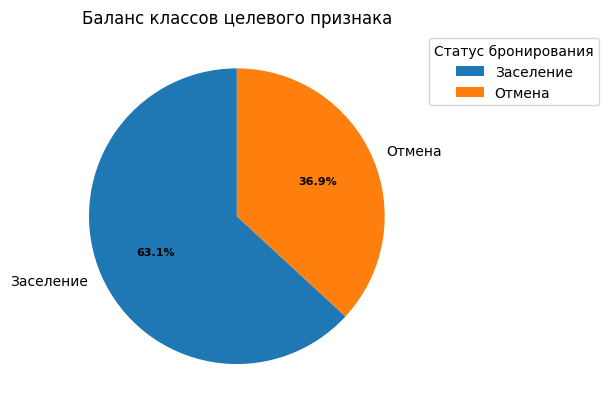

In [14]:
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(hotel_train['is_canceled'].value_counts(),
                                  autopct = '%1.1f%%',
                                  labels = ['Заселение', 'Отмена'],
                                  startangle = 90)

ax.legend(['Заселение', 'Отмена'],
          title ='Статус бронирования',
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ='bold')
ax.set_title('Баланс классов целевого признака')

plt.show()

Видим, что некоторый дисбаланс присутствует, но не критичный.

Далее составим таблицу корреляции наших параметров с целевым признаком и посмотрим, какие из них имеют большую связь:

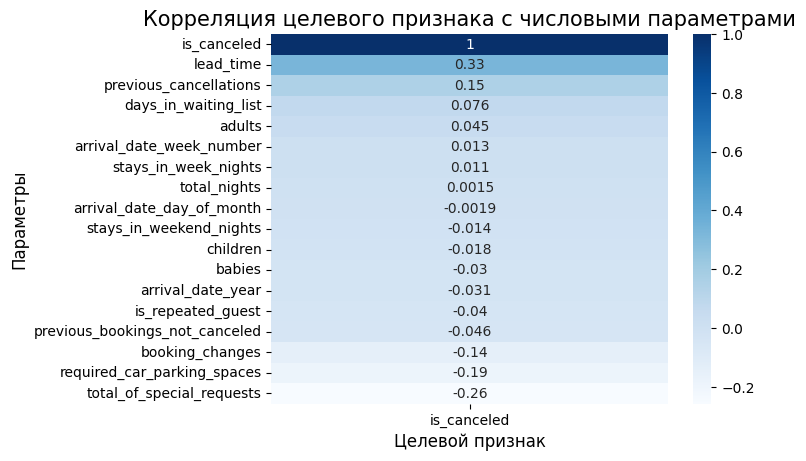

In [15]:
sns.heatmap(hotel_train.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
            annot = True,
            cmap='Blues')

plt.title('Корреляция целевого признака с числовыми параметрами', fontsize=15)
plt.xlabel('Целевой признак', fontsize=12)
plt.ylabel('Параметры', fontsize=12)

plt.show()

Наибольший коэффициент корреляции у признака отмены с количеством дней между датой бронирования и датой прибытия (0.33) - это может говорить о том, что в процессе долгого ожидания клиенты могут просто передумать - и с количеством специальных отметок (-0.26) - возможно отрицательная корреляция может говорить нам, что чем больше у гостя дополнительных пожеланий к номеру и отелю, тем больше у него внутренней уверенности, что именно наш отель ему подходит и что все его ожидания по бронированию оправдаются.

Далее сравним визуально общее количество бронирований и количество отмен по номеру недели и году:

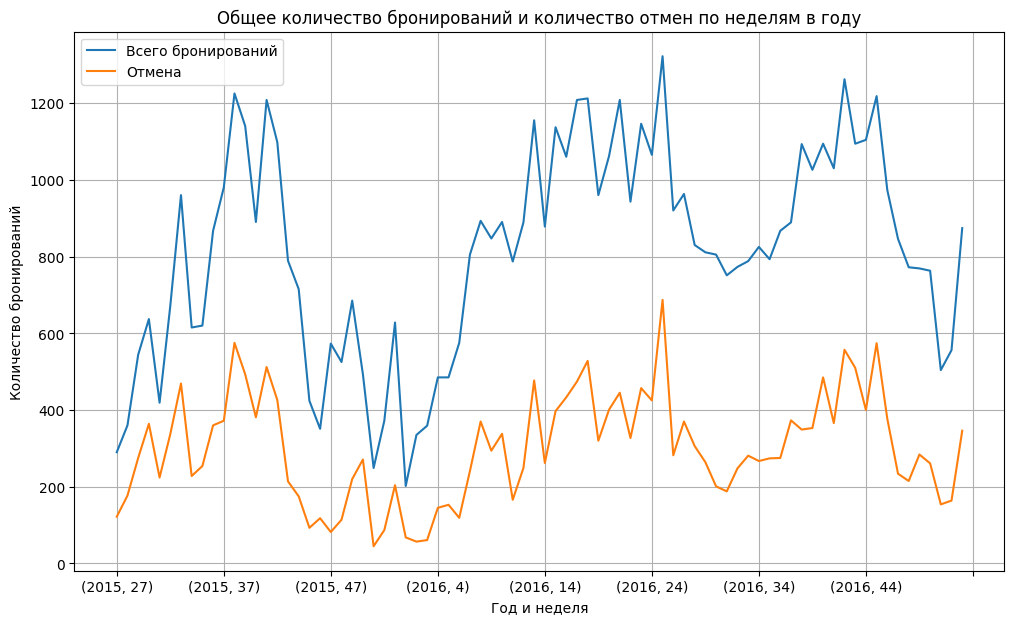

In [16]:
hotel_train.pivot_table(index=['arrival_date_year', 'arrival_date_week_number'],
                            values='is_canceled', aggfunc=['count', 'sum']).plot(kind='line', figsize=(12,7), grid=True)
plt.ylabel('Количество бронирований')
plt.xlabel('Год и неделя')
plt.title('Общее количество бронирований и количество отмен по неделям в году')
plt.legend(['Всего бронирований', 'Отмена']);
plt.show()

Можем отметить, что отметка отмены почти всегда развивается с той же динамикой, что и общее число бронирований, но в некоторых случаях приближается к этому показателю критически близко (например, середина и самый конец 2015 года). Также можем наблюдать, прирост бронирований с 14 по 26 неделю 2016 года (примерно апрель - июнь) и с 37 по 45 неделю 2015 и 2016 года (примерно сентябрь - ноябрь).

Просмотрим в процентном соотношении, какой тип номеров чаще всего отменяют:

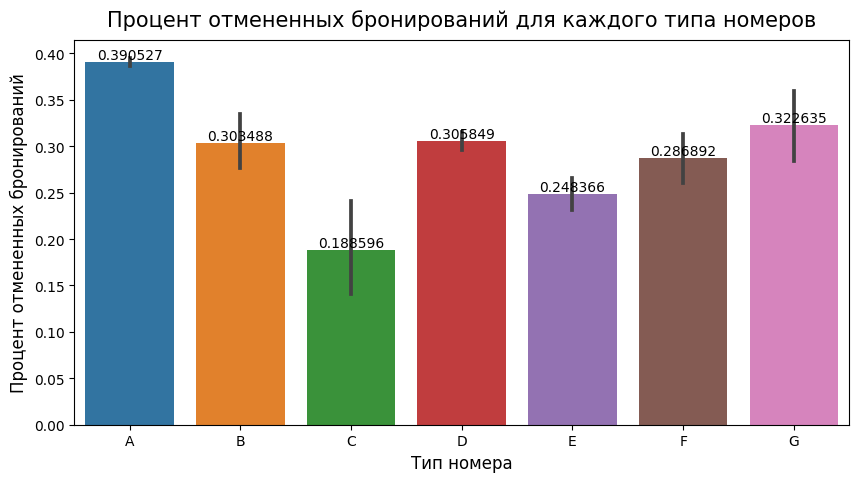

In [17]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = hotel_train, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'])
for i in ax.containers:
    ax.bar_label(i,)

plt.title("Процент отмененных бронирований для каждого типа номеров", fontsize = 15, pad = 10)
plt.xlabel("Тип номера", fontsize = 12)
plt.ylabel("Процент отмененных бронирований", fontsize = 12);
plt.show()

Чаще всего отменяют номера категории А (39%), далее по большему количеству отмены бронирований следуют номера категорий G (32%), D (31%) и B (30%).

Проверим наши данные на возможные выбросы. Загрузим опсиательную характеристику:

In [18]:
hotel_train.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


По показателям наиболее сомнительно выглядят столбцы ***lead_time*** и ***days_in_waiting_list***, так как именно у них подозрительно разнятся среднее и медиана. Построим для этих столбцов график распрделения:

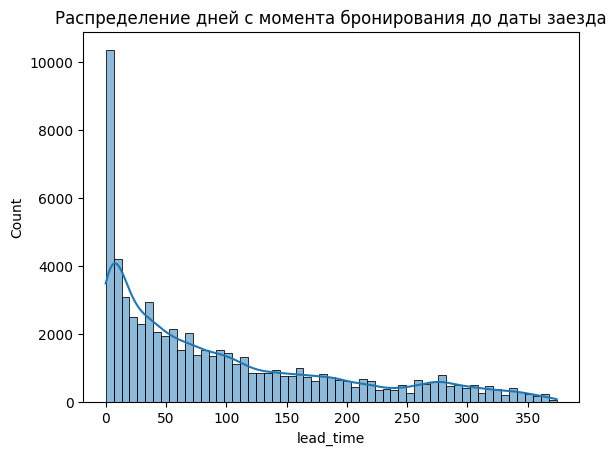

In [19]:
sns.histplot(hotel_train['lead_time'], kde=True)

plt.title('Распределение дней с момента бронирования до даты заезда')
plt.show()

По распределениию столбца ***lead_time*** можем сказать, что оно приближенно к распределению Пуассона. Явных критичных выбросов не заметно.

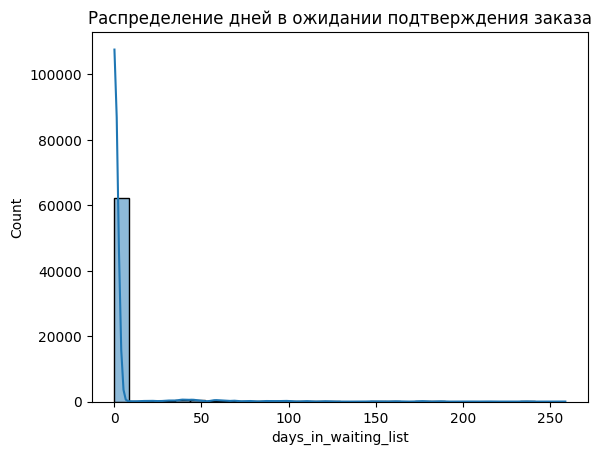

In [20]:
sns.histplot(hotel_train['days_in_waiting_list'], bins=30, kde=True)

plt.title('Распределение дней в ожидании подтверждения заказа')
plt.show()

Видим в распределении столбца days_in_waiting_list слошком большой разброс значений (от 0 до 259), при котором слишком большое количество нулей, поэтому немного ограничим график по оси X и Y, чтобы обрезать график:

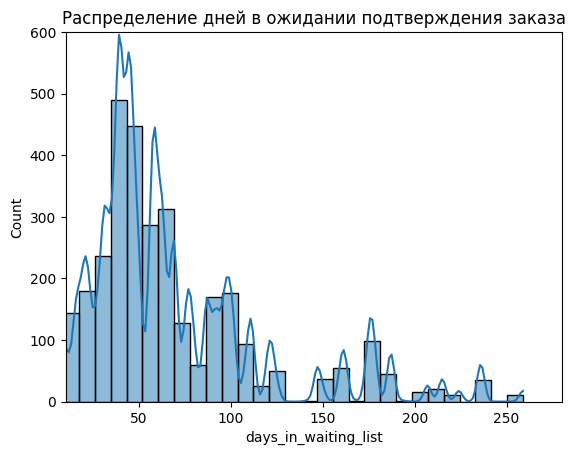

In [21]:
sns.histplot(hotel_train['days_in_waiting_list'], bins=30, kde=True)
plt.xlim(10, 280)
plt.ylim(0, 600)

plt.title('Распределение дней в ожидании подтверждения заказа')
plt.show()

Также можем заметить распределение, напоминающее нормальное, с небольшим количеством выбросов, но удалять их не станем, так как они не являются критичными.

### Выводы

Провели предобработку данных:
* проверили данные на дубликаты и пропуски;
* скорректировали и удалили лишние пробелы в данных;
* избавилимь от столбца ***id***, который мог бы помешать в дальнейших вычислениях.

Также более детально изучили данные с помощью исследовательского анализа:
* провели исследования дисбаланса классов и выяснили, что отменялось 36.9% бронирований;
* проверили корреляцию параметров с целевым признаком (наибольший коэффициент корреляции у признака отмены с количеством дней между датой бронирования и датой прибытия (0.33) и с количеством специальных отметок (-0.26));
* выявили, какой класс номеров отменяют чаще всего (чаще всего отменяют номера категории А (39%), далее по большему количеству отмены бронирований следуют номера категорий G (32%), D (31%) и B (30%));
* проверили сомнительные столбцы на выбросы и не выявили критичных показателей.

## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.


На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Перед началом расчётов и подготовки данных внесём дополнительные условия в отдельные датафреймы:

In [22]:
price_hotel_room = pd.DataFrame({'reserved_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                           'price_per_night': [1000, 800, 600, 550, 500, 450, 350],
                           'room_service': [400, 350, 350, 150, 150, 150, 150]})
price_hotel_room

,reserved_room_type,price_per_night,room_service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


In [23]:
coef_of_season = pd.DataFrame({'arrival_date_month': ['January', 'February', 'March', 'April', 'May', 'June',
                                    'July', 'August', 'September','October', 'November', 'December'],
                            'ratio': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0]})
coef_of_season

,arrival_date_month,ratio
0,January,1.0
1,February,1.0
2,March,1.2
3,April,1.2
4,May,1.2
5,June,1.4
6,July,1.4
7,August,1.4
8,September,1.2
9,October,1.2


Далее присоединим наши дополнительные входные данные к изначальному датафрейму:

In [24]:
hotel_train = hotel_train.merge(price_hotel_room, how='left', on='reserved_room_type')
hotel_train = hotel_train.merge(coef_of_season, how='left', on='arrival_date_month')
hotel_test = hotel_test.merge(price_hotel_room, how='left', on='reserved_room_type')
hotel_test = hotel_test.merge(coef_of_season, how='left', on='arrival_date_month')

Проеверяем результат присоединения:

In [25]:
hotel_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,room_service,ratio
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,Direct,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.4
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,2,1000,400,1.4
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,Direct,0,0,0,C,0,0,Transient,0,0,2,600,350,1.4
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,Direct,0,0,0,C,0,0,Transient,0,1,2,600,350,1.4
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1000,400,1.4


In [26]:
hotel_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,room_service,ratio
0,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.0
1,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.0
2,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.0
3,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.0
4,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.0


Переходим к корректрировке данных. Используем метод OHE для кодирования категориальных переменных и проверяем результат преобразований:

In [27]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
features = ohe.fit_transform(hotel_train[hotel_train.select_dtypes(include=['object']).columns])
features_columns = ohe.get_feature_names_out(hotel_train.select_dtypes(include = ['object']).columns)
ohe_train = pd.DataFrame(features, columns=features_columns)

print(ohe_train.shape)
ohe_train.head()

(65229, 26)


,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Применяем кодирование к тестовой выборке и также проверяем результат:

In [28]:
features = ohe.transform(hotel_test[hotel_test.select_dtypes(include=['object']).columns])
ohe_test = pd.DataFrame(features, columns=features_columns)

print(ohe_test.shape)
ohe_test.head()

(32412, 26)


,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Чтобы добавить наши закодированные категориальные признаки к нашим исходным датафреймам, исключим из них первоначальные категориальные столбцы:

In [29]:
numeric_train = hotel_train[hotel_train.select_dtypes(include=['int','float']).columns]
numeric_test = hotel_test[hotel_train.select_dtypes(include=['int','float']).columns]

Далее присоединяем закодированные признаки и проверяем результат:

In [30]:
ohe_train = pd.merge(numeric_train, ohe_train, left_index=True, right_index=True)
ohe_test = pd.merge(numeric_test, ohe_test, left_index=True, right_index=True)

print(ohe_train.shape)
ohe_test.head()

(65229, 47)


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,room_service,ratio,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74.0,2017,1,1,1,0,2.0,0.0,0.0,0,0,0,0,0,0,0,1,1000,400,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,62.0,2017,1,1,2,2,2.0,0.0,0.0,0,0,0,0,0,0,1,4,1000,400,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,62.0,2017,1,1,2,2,2.0,0.0,0.0,0,0,0,0,0,0,1,4,1000,400,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,71.0,2017,1,1,2,2,1.0,0.0,0.0,0,0,0,0,0,0,1,4,1000,400,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,172.0,2017,1,1,2,5,2.0,0.0,0.0,0,0,0,0,0,0,0,7,1000,400,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Делим получившейся набор данных на features и target в обеих выборках:

In [31]:
features_train = ohe_train.drop(['is_canceled'], axis=1)
target_train = ohe_train['is_canceled']

features_test = ohe_test.drop(['is_canceled'], axis=1)
target_test = ohe_test['is_canceled']

Переходим к масштабированию признаков:

In [32]:
pd.set_option('display.float_format', '{:,.2f}'.format) #cтрока для корректного вывода чисел

In [33]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train))
features_test = pd.DataFrame(scaler.transform(features_test))

Теперь проверяем данные, чтобы в обучающей выборке стандартное отклонение было строго равно 1, а среднее - 0, но в тестовой выборке лишь приближенно к этим показателям:

In [34]:
features_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
count,"65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00","65,229.00"
mean,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.00,-1.60,-2.25,-1.70,-0.97,-1.64,-3.82,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,-0.68,-1.18,-2.79,-1.94,-1.70,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,-2.25,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,-1.52,-0.59
25%,-0.83,-1.60,-0.77,-0.90,-0.97,-0.90,0.34,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,-0.68,-0.60,0.53,0.52,-0.15,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,0.44,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,-1.52,-0.59
50%,-0.34,0.63,0.20,0.02,0.20,-0.17,0.34,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,-0.68,-0.03,0.53,0.52,-0.15,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,0.44,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,0.66,-0.59
75%,0.57,0.63,0.79,0.82,1.38,0.57,0.34,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,0.65,0.55,0.53,0.52,1.40,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,0.44,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,0.66,1.70
max,2.89,0.63,1.61,1.73,3.72,2.79,4.50,8.75,101.15,5.99,26.80,43.64,28.30,14.02,12.68,5.96,4.00,0.53,0.52,1.40,2.96,3.30,4.29,5.79,3.23,3.61,3.84,3.60,3.21,2.46,2.54,11.98,2.82,3.20,2.92,25.65,0.44,8.65,16.88,2.44,5.06,7.26,10.45,15.04,0.66,1.70


In [35]:
features_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
count,"32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00","32,412.00"
mean,0.01,2.85,-1.01,-0.02,0.05,0.09,0.05,0.03,-0.02,0.03,-0.12,0.05,0.04,-0.17,-0.04,0.19,0.09,-0.12,-0.13,0.07,-0.02,-0.30,0.26,0.41,0.09,0.27,0.28,0.35,-0.31,-0.41,-0.39,-0.07,-0.12,0.26,0.02,0.03,0.00,-0.06,0.05,0.13,0.07,-0.02,-0.01,0.01,0.33,-0.27
std,0.90,0.00,0.68,1.00,1.00,1.01,1.02,1.03,0.77,1.07,0.19,1.41,1.08,0.26,0.95,1.11,1.00,1.07,1.08,1.13,0.97,0.00,1.41,1.77,1.11,1.35,1.39,1.43,0.00,0.00,0.00,0.40,0.83,1.30,1.03,1.31,1.00,0.67,1.33,1.12,1.15,0.91,0.97,1.08,0.78,0.79
min,-1.00,2.85,-2.25,-1.70,-0.97,-1.64,-3.82,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,-0.68,-1.18,-2.79,-1.94,-1.70,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,-2.25,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,-1.52,-0.59
25%,-0.76,2.85,-1.58,-0.90,-0.97,-0.90,0.34,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,-0.68,-0.60,-1.77,-1.94,-0.15,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,0.44,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,0.66,-0.59
50%,-0.21,2.85,-0.99,-0.04,0.20,-0.17,0.34,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,-0.68,-0.03,0.53,0.52,-0.15,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,0.44,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,0.66,-0.59
75%,0.61,2.85,-0.47,0.82,1.38,0.57,0.34,-0.22,-0.07,-0.17,-0.13,-0.08,-0.33,-0.18,-0.24,0.65,0.55,0.53,0.52,1.40,-0.34,-0.30,-0.23,-0.17,-0.31,-0.28,-0.26,-0.28,-0.31,-0.41,-0.39,-0.08,-0.35,-0.31,-0.34,-0.04,0.44,-0.12,-0.06,-0.41,-0.20,-0.14,-0.10,-0.07,0.66,-0.59
max,2.88,2.85,0.27,1.73,3.72,2.79,4.50,8.75,20.17,5.99,6.08,54.19,29.98,12.04,34.22,5.96,4.00,0.53,0.52,1.40,2.96,-0.30,4.29,5.79,3.23,3.61,3.84,3.60,-0.31,-0.41,-0.39,11.98,2.82,3.20,2.92,25.65,0.44,8.65,16.88,2.44,5.06,7.26,10.45,15.04,0.66,1.70


Масштабирование проведено успешно.

Далее напишем функцию для расчёта прибыли за период в тестовой выборке (с января по август 2017 года). Для этого в отдельный датафрейм вынесем все признаки, необходимые для расчётов:

In [36]:
hotel_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,room_service,ratio
0,1,74.00,2017,January,1,1,1,0,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.00
1,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.00
2,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.00
3,1,71.00,2017,January,1,1,2,2,1.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.00
4,1,172.00,2017,January,1,1,2,5,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.00


In [37]:
features_for_profit = hotel_test[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights', 'price_per_night',
                                  'room_service', 'ratio']]
features_for_profit.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,room_service,ratio
0,1,January,A,1,1000,400,1.00
1,1,January,A,4,1000,400,1.00
2,1,January,A,4,1000,400,1.00
3,1,January,A,4,1000,400,1.00
4,1,January,A,7,1000,400,1.00


Теперь создаём функцию расчёта прибыли, согласно первоначальным учловиям, и применяем функцию для создания нового столбца в нашей таблице:

In [38]:
def profit(row):
    if row['is_canceled'] == 0:
        income = row['price_per_night'] * row['total_nights'] * row['ratio']
        expenses = row['room_service'] * (round(row['total_nights']/2) + 1)
    else:
        income = 0
        expenses = row['price_per_night'] * row['ratio'] + row['room_service']
    profit = income - expenses
    return profit

In [39]:
features_for_profit['total_profit'] = features_for_profit.apply(profit, axis=1)
features_for_profit

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,room_service,ratio,total_profit
0,1,January,A,1,1000,400,1.00,"-1,400.00"
1,1,January,A,4,1000,400,1.00,"-1,400.00"
2,1,January,A,4,1000,400,1.00,"-1,400.00"
3,1,January,A,4,1000,400,1.00,"-1,400.00"
4,1,January,A,7,1000,400,1.00,"-1,400.00"
...,...,...,...,...,...,...,...,...
32407,0,August,A,6,1000,400,1.40,"6,800.00"
32408,0,August,A,7,1000,400,1.40,"7,800.00"
32409,0,August,A,7,1000,400,1.40,"7,800.00"
32410,0,August,D,7,550,150,1.40,"4,640.00"


In [70]:
print('Прибыль отеля без внедрения депозитов с января по августь 2017 года составляет',
      features_for_profit['total_profit'].sum())

Прибыль отеля без внедрения депозитов с января по августь 2017 года составляет 30665270.0


### Выводы

В данном этапе мы успешно подготовили данные для дальнейшего обучения будущих моделей (провели кодирование категориальных признаков методом OHE провели масштабирование). Также рассчитали итоговую прибыль отеля без внедрения депозитов с помощью функции за период с января по август 2017 года, которая составила 30 665 270 руб.

## Шаг 4. Разработка модели ML

Пропишем функцию, которая будет сразу же считать предсказания для наших будущих моделей, просчитывать метрики F1 и ROC_AUC, а также строить ROC-кривую для визуализации:

In [41]:
def metrics_model(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

    print('F1:', f1_score(target, prediction))
    print('ROC_AUC:', roc_auc_score(target, proba_one))
    return prediction

Ключевой метрикой для обучения выбираем показатель F1, так как он является в нашем случае наиболее оптимальным, потому что позволяет нам грамотно объединить precision и recall в агрегированный критерий качества.

Начнём с обучения модели логистической регрессии и сразу просчитаем показатели по кросс-валидации:

### Логистическая регрессия

In [42]:
model_log = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced')
model_log.fit(features_train, target_train)

print('Средний показатель оценки F1 на кросс-валидации для логистической регрессии:',
      cross_val_score(model_log, features_train, target_train, cv=5, scoring='f1').mean())

Средний показатель оценки F1 на кросс-валидации для логистической регрессии: 0.37999524535055124


In [44]:
print(f'Лучший F1 на тестовой выборке: {model_log.score(features_test, target_test)}')

Лучший F1 на тестовой выборке: 0.658830062939652


Видим результаты по ключевой метрике F1 - 0.65 для тестовой выборки. Далее посмотрим на остальные параметры:

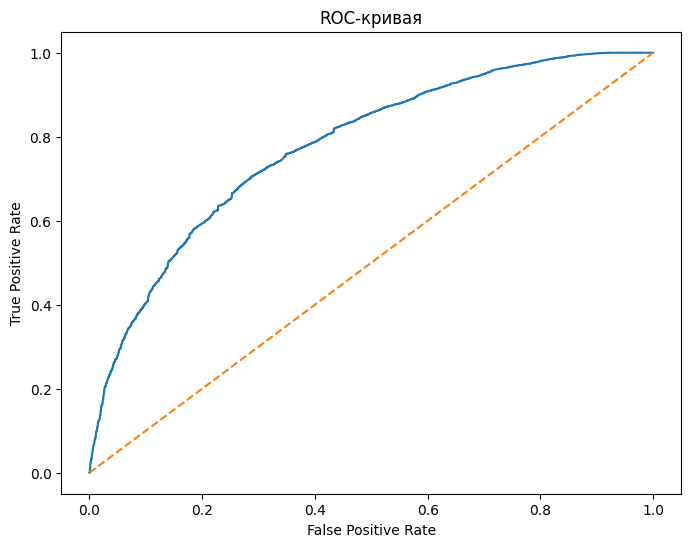

F1: 0.6532237832413447
ROC_AUC: 0.7771750379301148


array([1, 0, 0, ..., 1, 0, 1])

In [43]:
metrics_model(model_log, features_test, target_test)

По метрикам и графику можем оценить, что модель адекватна. Переходим к обучению дерева решений:

### Дерево решений

In [45]:
tree_params = {
    'max_depth': range(0, 21),
    'criterion': ['gini', 'entropy', 'log_loss']
}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                         tree_params, cv = 5, scoring = 'f1')
model_tree = tree_grid.fit(features_train, target_train)
print('Оптимальные параметры для дерева решений:', model_tree.best_params_)

Оптимальные параметры для дерева решений: {'criterion': 'gini', 'max_depth': 2}


In [46]:
print(f'Лучший F1 на тестовой выборке: {model_tree.score(features_test, target_test)}')

Лучший F1 на тестовой выборке: 0.5737622602349948


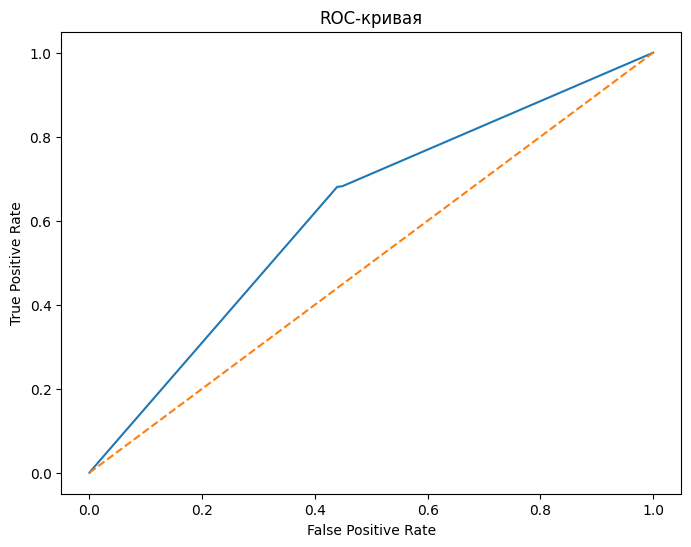

F1: 0.5737622602349948
ROC_AUC: 0.6196369668007661


array([1, 0, 0, ..., 1, 0, 1])

In [47]:
metrics_model(model_tree, features_test, target_test)

Модель дерева решений дала нам показатель метрики F1 0.57, что существенно ниже, чем у логистической регрессии. Переходим к модели случайного леса:

### Случайный лес

In [48]:
forest_params = {                       # ранее проверялись значения гиперпарпметров с большим разбросом но сократили интервалы в пользу
    'criterion':['gini','entropy'],     # скорости выполнения ячейки таким образом, чтобы на выходе получались те же гиперпараметры
    'n_estimators': range(5, 20, 5),    # ранее проверяли интервалом range(5, 65, 5)
    'max_depth': range(2, 10, 2)}       # ранее проверяли интервалом range(1, 21)
forest_grid = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                     forest_params, cv = 5, scoring = 'f1', verbose=2)
model_forest = forest_grid.fit(features_train, target_train)

print('Оптимальные параметры для случайного леса:', model_forest.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ........criterion=gini, max_depth=2, n_estimators=5; total time=   0.1s
[CV] END ........criterion=gini, max_depth=2, n_estimators=5; total time=   0.1s
[CV] END ........criterion=gini, max_depth=2, n_estimators=5; total time=   0.1s
[CV] END ........criterion=gini, max_depth=2, n_estimators=5; total time=   0.1s
[CV] END ........criterion=gini, max_depth=2, n_estimators=5; total time=   0.1s
[CV] END .......criterion=gini, max_depth=2, n_estimators=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=2, n_estimators=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=2, n_estimators=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=2, n_estimators=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=2, n_

In [49]:
print('Оптимальные параметры для случайного леса:', model_forest.best_params_)

Оптимальные параметры для случайного леса: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 5}


In [50]:
print(f'Лучший F1 на тестовой выборке: {model_forest.score(features_test, target_test)}')

Лучший F1 на тестовой выборке: 0.628016458464618


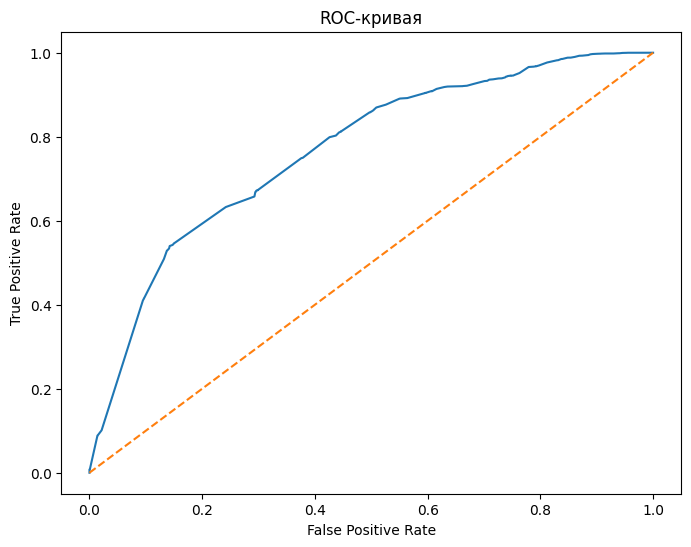

F1: 0.628016458464618
ROC_AUC: 0.7667383526530359


array([1, 0, 0, ..., 1, 0, 1])

In [51]:
metrics_model(model_forest, features_test, target_test)

Видим, что модель случайного леса также является адекватной, но показатели её метрик всё ещё ниже, что у логистической регрессии: F1 - 0.63.

В отдельную таблицу для наглядности соберём значения ключевой метрики F1 на обучающей и тестовой выборке для всех трёх моделей:

In [54]:
f1_of_models = pd.DataFrame(data=[('Логистическая Регрессия', model_log.score(features_test, target_test)),
                                  ('Дерево Решений', model_tree.score(features_test, target_test)),
                                  ('Случайный Лес', model_forest.score(features_test, target_test))],
                                  columns=['Модель', 'F1 для тестовой выборки'])
f1_of_models

,Модель,F1 для тестовой выборки
0,Логистическая Регрессия,0.66
1,Дерево Решений,0.57
2,Случайный Лес,0.63


Можем сделать вывод, что лучше всего себя показала модель логистической регрессии.

### Расчёт прибыли

 Далее оценим потенциальную прибыль для всех трёх моделей. Для этого в начале создаём функцию для подсчёта прибыли по предсказаниям модели:

In [55]:
def profit_prediction(row, col):
    if row['is_canceled'] == 0:
        income = row['price_per_night'] * row['total_nights'] * row['ratio']
        expenses = row['room_service'] * (round(row['total_nights']/2) + 1)
    elif (row[col] == 0) and (row['is_canceled'] == 1):
        income = 0
        expenses = row['room_service'] + (row['price_per_night'] * row['ratio'])
    elif (row[col] == 1) and (row['is_canceled'] == 1):
        income= row['price_per_night'] * 0.8
        expenses = row['room_service']
    profit = income - expenses
    return profit

Теперь занесём предсказания каждой из моделей в отдельные столбцы для удобства. Тут же проверяем результат:

In [56]:
features_for_profit['prediction_log'] = model_log.predict(features_test)
features_for_profit['prediction_tree'] = model_tree.predict(features_test)
features_for_profit['prediction_forest'] = model_forest.predict(features_test)
features_for_profit.head(10)

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,room_service,ratio,total_profit,prediction_log,prediction_tree,prediction_forest
0,1,January,A,1,1000,400,1.00,"-1,400.00",1,1,1
1,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0
2,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0
3,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0
4,1,January,A,7,1000,400,1.00,"-1,400.00",1,1,1
5,1,January,A,7,1000,400,1.00,"-1,400.00",1,1,1
6,1,January,A,2,1000,400,1.00,"-1,400.00",0,0,0
7,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0
8,1,January,E,4,500,150,1.00,-650.00,1,1,1
9,1,January,A,5,1000,400,1.00,"-1,400.00",0,0,0


Теперь, применив функцию выше, добавим ещё несколько столбцов, которые будут хранить информацию о потенциальной прибыли для каждого гостя по результатм предсказаний:

In [57]:
features_for_profit['profit_log'] = features_for_profit.apply(profit_prediction, col='prediction_log', axis=1)
features_for_profit['profit_tree'] = features_for_profit.apply(profit_prediction, col='prediction_tree', axis=1)
features_for_profit['profit_forest'] = features_for_profit.apply(profit_prediction, col='prediction_forest', axis=1)
features_for_profit.head(10)

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,room_service,ratio,total_profit,prediction_log,prediction_tree,prediction_forest,profit_log,profit_tree,profit_forest
0,1,January,A,1,1000,400,1.00,"-1,400.00",1,1,1,400.00,400.00,400.00
1,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0,"-1,400.00","-1,400.00","-1,400.00"
2,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0,"-1,400.00","-1,400.00","-1,400.00"
3,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0,"-1,400.00","-1,400.00","-1,400.00"
4,1,January,A,7,1000,400,1.00,"-1,400.00",1,1,1,400.00,400.00,400.00
5,1,January,A,7,1000,400,1.00,"-1,400.00",1,1,1,400.00,400.00,400.00
6,1,January,A,2,1000,400,1.00,"-1,400.00",0,0,0,"-1,400.00","-1,400.00","-1,400.00"
7,1,January,A,4,1000,400,1.00,"-1,400.00",0,0,0,"-1,400.00","-1,400.00","-1,400.00"
8,1,January,E,4,500,150,1.00,-650.00,1,1,1,250.00,250.00,250.00
9,1,January,A,5,1000,400,1.00,"-1,400.00",0,0,0,"-1,400.00","-1,400.00","-1,400.00"


Считаем общую прибыль после внедрения моделей:

In [58]:
print('Прибыль после обучения модели Логистической Регрессии:', features_for_profit['profit_log'].sum())
print('Прибыль после обучения модели Дерева Решений:', features_for_profit['profit_tree'].sum())
print('Прибыль после обучения модели Случайного Леса:', features_for_profit['profit_forest'].sum())

Прибыль после обучения модели Логистической Регрессии: 49612630.0
Прибыль после обучения модели Дерева Решений: 46311400.0
Прибыль после обучения модели Случайного Леса: 46514440.0


Можем отметить, что и здесь лучшие результаты остаются за моделью логистической регрессии. Вычтем из прибыли, которую принесла бы модель, фактическую выручку:

In [71]:
print('Модель Логистической Регрессии принесёт компании прибыль:',
      features_for_profit['profit_log'].sum() - features_for_profit['total_profit'].sum())

print('Модель Дерева Решений принесёт компании прибыль:',
      features_for_profit['profit_tree'].sum().sum() - features_for_profit['total_profit'].sum())

print('Модель Случайного Леса принесёт компании прибыль:',
      features_for_profit['profit_forest'].sum() - features_for_profit['total_profit'].sum())

Модель Логистической Регрессии принесёт компании прибыль: 18947360.0
Модель Дерева Решений принесёт компании прибыль: 15646130.0
Модель Случайного Леса принесёт компании прибыль: 15849170.0


По результатам расчётов видим, что модель полностью и с лихвой окупает бюджет на свою разработку (400 000 рублей). Лучшие показатели всё-таки у модели логистической регрессии, поэтому настоятельно рекомендуем использовать для разработки именно её.

### Выводы

Мы обучили три разновидности моделей для задачи классификации: логистическую регрессию, дерево решений и случайный лес. Выбрали ключевую метрику F1 и по ней сравнивали и оценивали результаты. По итогам расчётов лучше всего себя показала модель Логистической регресси с результатом 0.65 для тестовой выборки.

Далее написали функцию и расчитали потенциальную прибыль, которую могла бы принести модель компании. В этих расчетах снова выигрышной оказалась модель Логистической регресси со следующими результатами: общая выручка 49 612 630 руб и доп выручка при внедрения модели 18 947 360 руб. Такие показатели поражают и полностью отбивают расходы на разработку проекта (заложенный бюджет составляет 400 000 руб).

## Шаг 5. Опишите портрет «ненадёжного» клиента

Присоединим предсказания модели в отдельной колонке к тестовой выборке для дальнейших расчётов и сравнений:

In [60]:
hotel_test['prediction_log'] = features_for_profit['prediction_log']
hotel_test.head(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_per_night,room_service,ratio,prediction_log
0,1,74.00,2017,January,1,1,1,0,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.00,1
1,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.00,0
2,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.00,0
3,1,71.00,2017,January,1,1,2,2,1.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.00,0
4,1,172.00,2017,January,1,1,2,5,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.00,1
5,1,52.00,2017,January,1,1,2,5,1.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.00,1
6,1,143.00,2017,January,1,2,1,1,2.00,0.00,0.00,BB,Direct,0,0,0,A,1,0,Transient,0,1,2,1000,400,1.00,0
7,1,21.00,2017,January,1,2,1,3,2.00,0.00,0.00,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.00,0
8,1,89.00,2017,January,1,2,1,3,2.00,0.00,0.00,BB,TA/TO,0,0,0,E,0,0,Transient,0,0,4,500,150,1.00,1
9,1,48.00,2017,January,1,2,1,4,2.00,0.00,0.00,BB,Direct,0,0,0,A,1,0,Transient,0,2,5,1000,400,1.00,0


Первым делом посмотрим на соотношение в процентах заселения к отмене бронирования по результатам прдесказаний модели:

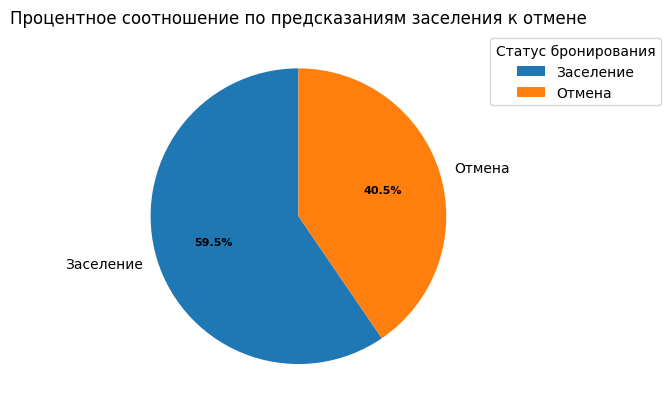

In [61]:
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(hotel_test['prediction_log'].value_counts(),
                                  autopct = '%1.1f%%',
                                  labels = ['Заселение', 'Отмена'],
                                  startangle = 90)

ax.legend(['Заселение', 'Отмена'],
          title ='Статус бронирования',
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ='bold')
ax.set_title('Процентное соотношение по предсказаниям заселения к отмене')

plt.show()

Видим, что в более чем 40% случаев модель предсказывает отмену бронирования. Построим диаграмму, что узнать реальное обстоятельство дел:

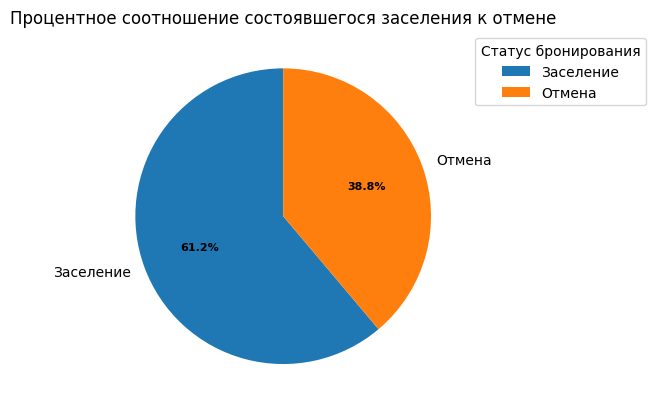

In [62]:
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(hotel_test['is_canceled'].value_counts(),
                                  autopct = '%1.1f%%',
                                  labels = ['Заселение', 'Отмена'],
                                  startangle = 90)

ax.legend(['Заселение', 'Отмена'],
          title ='Статус бронирования',
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ='bold')
ax.set_title('Процентное соотношение состоявшегося заселения к отмене')

plt.show()

Показатели очень близки друг к другу - в реальности отменяют бронирование 38,8% постояльцев. Посмотрим матрицу ошибок, чтобы оценить уровень предсказаний нашей модели:

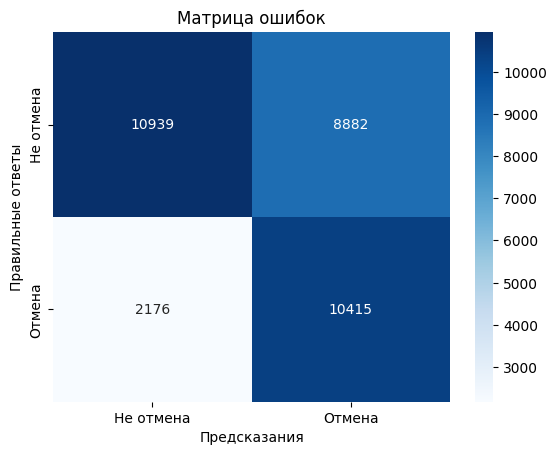

In [63]:
sns.heatmap(confusion_matrix(target_test, model_log.predict(features_test)), annot=True, cmap='Blues', fmt='g',
               xticklabels=['Не отмена', 'Отмена'], yticklabels=['Не отмена', 'Отмена'])

plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Правильные ответы')
plt.show()

Видим, что в большинстве случаев наша модель даёт корректные предсказания, но, к сожалению, примерно в трети от общей доли случаев ошибается. Заметим, что гораздо чаще она ошибается в сторону отмены, когда по факту клиент не отменяет бронирование, что гораздо лучше для бизнеса, чем обратная ситуация.

Посмотрим таблицу корреляции предсказаний модели с признаками и посмотрим, какие именно из них больше всего влияют на результаты предсказаний:

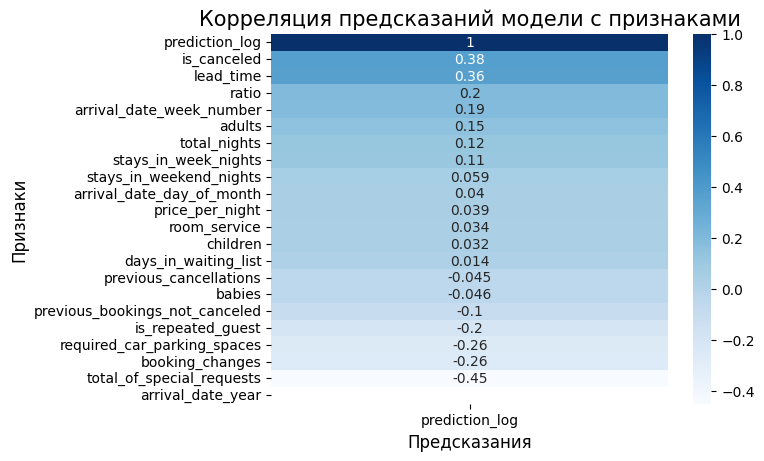

In [64]:
sns.heatmap(hotel_test.corr()[['prediction_log']].sort_values('prediction_log', ascending=False),
            annot = True,
            cmap='Blues')

plt.title('Корреляция предсказаний модели с признаками', fontsize=15)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Признаки', fontsize=12)

plt.show()

Можем подсветить несколько моментов:
* Чем больше у клиента специальных пожеланий к номеру и обслуживанию, тем больше мы можем быть уверены, что клиент не отменит бронирование. Причиной этому может быть уверенность в дополнительном комфорте, который наш отель предоставляет и позволяет скорректировать под пожелания любого гостя.
* Чем больше количество дней между датой бронирования и датой прибытия, тем больше вероятность того, что гость отменит бронирование. Такое может происходить по причине того, что у клиента много времени, чтобы передумать.
* Также такие признаки, как количество изменений в параметрах заказа и необходимость парковки для автомобилей, имеют одинаковое на уровне влияние на отмену брони. Отсутствие данных пометок может сказать нам о том, что гость задумается об отмене бронирования в нашем отеле.


Посмотрим ту же статистику на действительных данных об отмене:

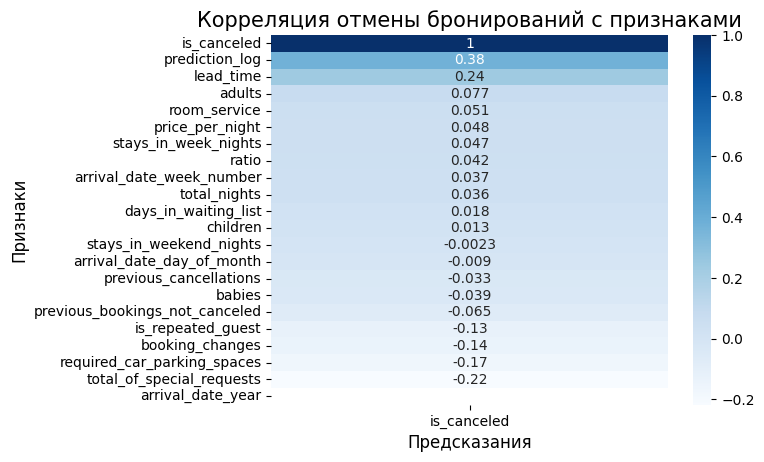

In [65]:
sns.heatmap(hotel_test.corr()[['is_canceled']].sort_values('is_canceled', ascending=False),
            annot = True,
            cmap='Blues')

plt.title('Корреляция отмены бронирований с признаками', fontsize=15)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Признаки', fontsize=12)

plt.show()

Видим похожую картину, что и ранее с предсказаниями, что только больше подтверждает наши выводы, прописанные ранее. И также говорит нам о том, что предсказания модели во многом достоверны и опираются на необходимые признаки.

Далее построим несколько столбчатых диаграмм и сравним насколько точно наша модель может предсказать клиента, склонного к отмене бронирования.

Посмотрим на процентную составляющую отмены по типам номеров. В начале взглянем на данные по предсказаниям:

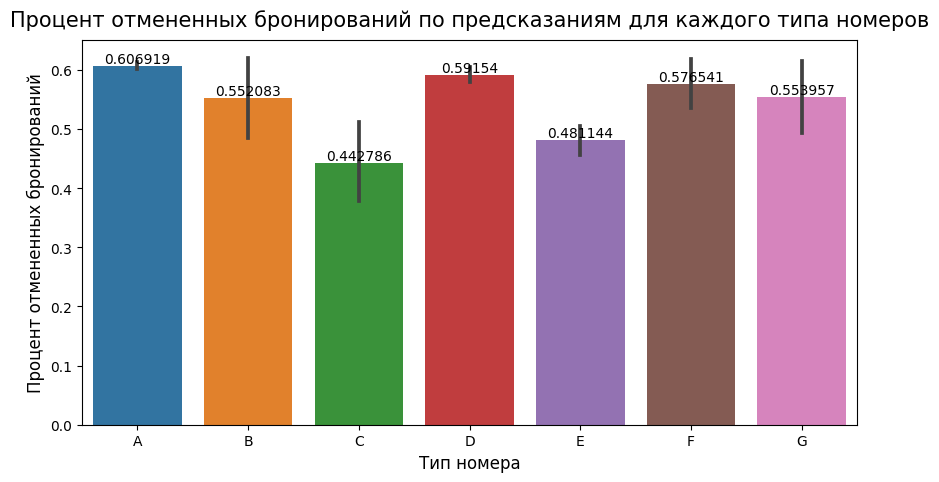

In [66]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = hotel_test, x='reserved_room_type', y='prediction_log', order = ['A','B','C','D','E','F','G'])
for i in ax.containers:
    ax.bar_label(i,)

plt.title("Процент отмененных бронирований по предсказаниям для каждого типа номеров", fontsize = 15, pad = 10)
plt.xlabel("Тип номера", fontsize = 12)
plt.ylabel("Процент отмененных бронирований", fontsize = 12);
plt.show()

Видим, что модель более часто припысывает отмену бронирования тем, кто собирается заселить в номер типов A, D и F.

Посмотим, как обстоят дела на самом деле:

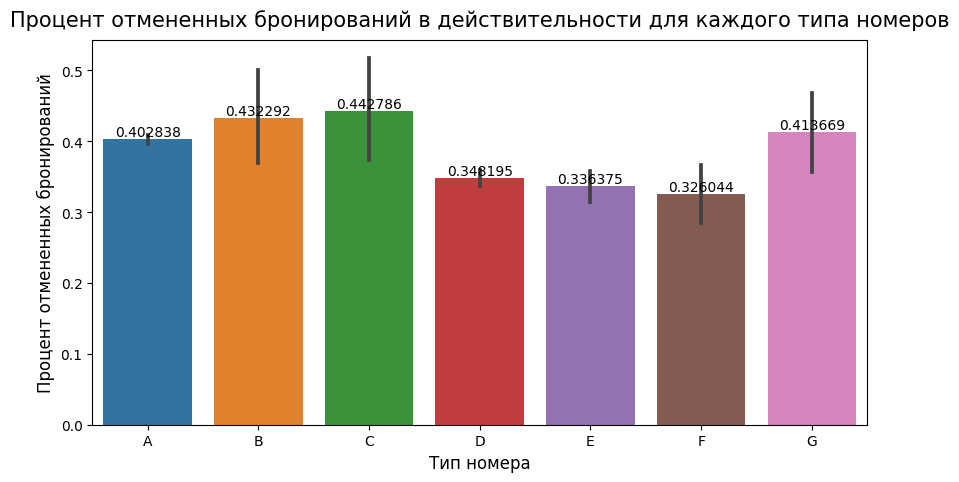

In [67]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = hotel_test, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'])
for i in ax.containers:
    ax.bar_label(i,)

plt.title("Процент отмененных бронирований в действительности для каждого типа номеров", fontsize = 15, pad = 10)
plt.xlabel("Тип номера", fontsize = 12)
plt.ylabel("Процент отмененных бронирований", fontsize = 12);
plt.show()

Видим, что а реальности чаще всего отменяют бронирование те гости, которые планируют заселяться в номера типов C, B и G. Только уже после них по количеству отмен от общего числа бронирований по типу номера следует категория А.

Проверим также такой категориальный признак, как тип клиента:

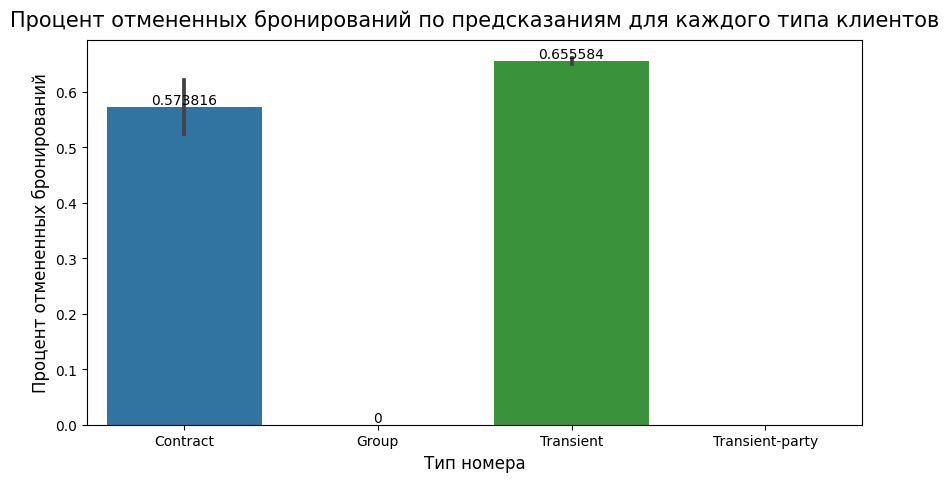

In [68]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = hotel_test, x='customer_type', y='prediction_log', order = ['Contract','Group',
                                                                                    'Transient','Transient-party'])
for i in ax.containers:
    ax.bar_label(i,)

plt.title("Процент отмененных бронирований по предсказаниям для каждого типа клиентов", fontsize = 15, pad = 10)
plt.xlabel("Тип номера", fontsize = 12)
plt.ylabel("Процент отмененных бронирований", fontsize = 12);
plt.show()

Видим, что в глазах модели все отмены приходятся на долю клиентов, не связаных с договором или групповым заездом, а также на договоры с юридическим лицом. Посмотрим, как обстоят дела в реальности:

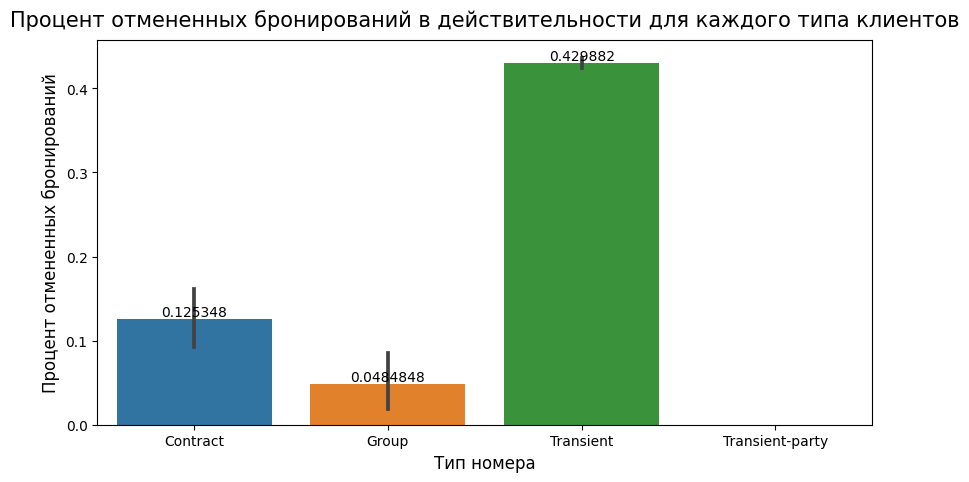

In [69]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = hotel_test, x='customer_type', y='is_canceled', order = ['Contract','Group',
                                                                                 'Transient','Transient-party'])
for i in ax.containers:
    ax.bar_label(i,)

plt.title("Процент отмененных бронирований в действительности для каждого типа клиентов", fontsize = 15, pad = 10)
plt.xlabel("Тип номера", fontsize = 12)
plt.ylabel("Процент отмененных бронирований", fontsize = 12);
plt.show()

Общая тенденция сохраняется, но показатели в дествительности не такие большие, как у модели.

### Выводы

**Портрет "ненадёжного" клиента глазами модели** состоит из следующих пунктов:

* большое количество дней между датой бронирования и датой заселения;
* отсутствуют пометки о дополнительных услугах или пожеланиях;
* нет запроса на парковочное место для автомобиля, а также отсуствуют изменения параметров в бронировании;
* гость желает заселиться в типы номеров A, D и F;
* клиент является юридическим лицом или же никаким образом не связан с договором или групповым заездом.

## Шаг 6. Напишите общий вывод

Данный проект проходил в несколько шагов выполнения:

**Шаг 1. Открыли файлы с данными.**

Первое, что мы сразу можем увидели, что обучающая выборка изначально больше тестовой примерно в 2 раза. Также отметим, что в обоих датафреймах отсутствуют пропуски.

**Шаг 2. Предобработка и исследовательский анализ данных**

Проверили данные и откорректировали их.
Провели исследовательский анализ представленных данных и описали найденные особенности.

Провели предобработку данных:

* проверили данные на дубликаты и пропуски;
* скорректировали и удалили лишние пробелы в данных;
* избавилимь от столбца id, который мог бы помешать в дальнейших вычислениях.

Также более детально изучили данные с помощью исследовательского анализа:

* провели исследования дисбаланса классов и выяснили, что отменялось 36.9% бронирований;
* проверили корреляцию параметров с целевым признаком (наибольший коэффициент корреляции у признака отмены с количеством дней между датой бронирования и датой прибытия (0.33) и с количеством специальных отметок (-0.26));
* выявили, какой класс номеров отменяют чаще всего (чаще всего отменяют номера категории А (39%), далее по большему количеству отмены бронирований следуют номера категорий G (32%), D (31%) и B (30%));
* проверили сомнительные столбцы на выбросы и не выявили критичных показателей.

**Шаг 3. Вычислили бизнес-метрику**

В данном этапе мы успешно подготовили данные для дальнейшего обучения будущих моделей (провели кодирование категориальных признаков методом OHE провели масштабирование). Также рассчитали итоговую прибыль отеля без внедрения депозитов с помощью функции за период с января по август 2017 года, которая составила 30 665 270 руб.

**Шаг 4. Разработка модели ML**

Мы обучили три разновидности моделей для задачи классификации: логистическую регрессию, дерево решений и случайный лес. Выбрали ключевую метрику F1 и по ней сравнивали и оценивали результаты. По итогам расчётов лучше всего себя показала модель Логистической регресси с результатом 0.65 для тестовой выборки.

Далее написали функцию и расчитали потенциальную прибыль, которую могла бы принести модель компании. В этих расчетах снова выигрышной оказалась модель Логистической регресси со следующими результатами: общая выручка 49 612 630 руб и доп выручка при внедрения модели 18 947 360 руб. Такие показатели поражают и полностью отбивают расходы на разработку проекта (заложенный бюджет составляет 400 000 руб).

**Шаг 5. Выявили признаки «ненадёжного» клиента**

Портрет "ненадёжного" клиента глазами модели состоит из следующих пунктов:

* большое количество дней между датой бронирования и датой заселения;
* отсутствуют пометки о дополнительных услугах или пожеланиях;
* нет запроса на парковочное место для автомобиля, а также отсуствуют изменения параметров в бронировании;
* гость желает заселиться в типы номеров A, D и F;
* клиент является юридическим лицом или же никаким образом не связан с договором или групповым заездом.